# An introduction to Linear Regression using linear models

## Agenda

- What is a **linear regression**, and how does it work?
- How to train a linear model with **multidimensional** inputs?
- What is a **basis function** and how to use to fit function with different shapes?
- How to apply **regularization** techniques?
- How do I choose **which features to include** in my model?
- How do I **train and interpret** a linear regression model in scikit-learn?


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Types of supervised learning

- **Regression:** Predict a continuous response

## Simple Linear Regression
Let's suppose to have data as pairs $D = \{(x^{(1)},t^{(1)}), ..., (x^{(N)},t^{(N)}) \}$ where
- $x$ is the input feature
- $t$ is the target output
Our aim is to fit a model, which is a function, with the following shape: $$ y(x)=w_0 +w_1x$$ where $w_0$ is called **bias** and $w_1$ is called **coefficient**, and they are both unknown.
Since the model is **fixed**, our assumption is that a linear model can be represented of the underline distribution in our data. 

To learn the parameters, we need an optimization algorithm and a loss function. Standard loss function is the **squared loss**.

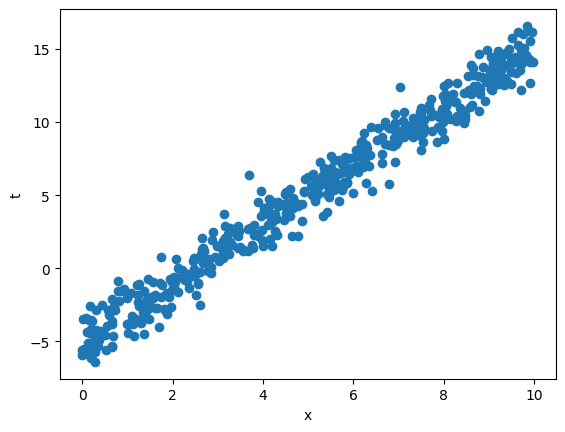

In [2]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(500)
t = 2 * X - 5 + rng.randn(500)
plt.scatter(X, t)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

We split the data in training and test dataset, we will learn the parameters on the training and then we will evaluate on the test set.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

We can use Scikit-Learn's `LinearRegression` estimator to fit this data and construct the best-fit line.

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True, n_jobs=-1)

Now we can fit the model on the training data and learn the parameters.

In [5]:
model.fit(X_train[:, np.newaxis], t_train)

LinearRegression(n_jobs=-1)

The slope and intercept of the data are contained in the model's fit parameters, which in Scikit-Learn are always marked by a trailing underscore.
Here the relevant parameters are `coef_` and `intercept_`:

In [6]:
print(f'Model intercept (w0): {model.intercept_}')
print(f'Model slope (w1):     {model.coef_[0]}')

Model intercept (w0): -5.088540621328555
Model slope (w1):     2.019347560843945


We can check the shape of the function that we have fitted.

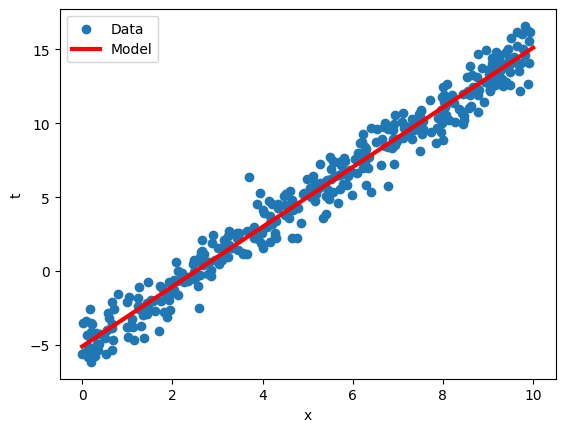

In [7]:
X_train_fit = np.linspace(0, 10, 1000)
t_train_fit = model.predict(X_train_fit[:, np.newaxis])
plt.scatter(X_train, t_train)
plt.plot(X_train_fit, t_train_fit, color='red', linewidth=3)
plt.legend(['Data', 'Model'], loc='best')
plt.xlabel('x')
plt.ylabel('t')
plt.show()

Finally, we can evaluate our model on the test set.

In [8]:
print(f'R2 score on the test set: {model.score(X_test[:, np.newaxis], t_test):3f}')

R2 score on the test set: 0.967692


## Linear Regression with Multi-dimensional Inputs 
The `LinearRegression` estimator is much more capable than this, however—in addition to simple straight-line fits, it can also handle multidimensional linear models of the form:

$$
y(\textbf{x}) = w_0 +  \sum_{j=1}^{d} w_jx_j = \textbf{w}^T \textbf{x}
$$

Geometrically, this is akin to fitting a plane to points in three dimensions, or fitting a hyperplane to points in higher dimensions.


### Linear Regression with two inputs

In [9]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(250, 2)
t = 0.5 + X[:,0] * rng.rand(250) + X[:,1] * 1.5 * rng.rand(250)

Let's visualize our data in the space.

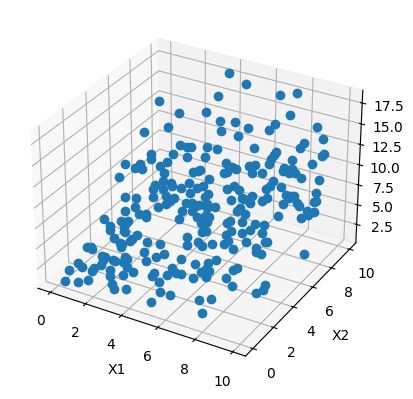

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(X[:,0], X[:,1], t, 'o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('t')
plt.show()

Again, let's split our dataset in training and test.

In [11]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

We can now fit our linear regression model.

In [12]:
model = LinearRegression(fit_intercept=True, n_jobs=-1)
model.fit(X_train, t_train)

LinearRegression(n_jobs=-1)

In [13]:
print(f'Model intercept (w0): {model.intercept_}')
print(f'Model slope (w1, w2): {model.coef_}')

Model intercept (w0): 0.8714503689577455
Model slope (w1, w2): [0.46031369 0.68312462]


Let's define the equation of the fitted regression plane.

In [14]:
# Create a mesh grid for plotting the plane
x_surf, y_surf = np.meshgrid(np.linspace(X_train[:,0].min(), X_train[:,0].max(), 200), 
                             np.linspace(X_train[:,1].min(), X_train[:,1].max(), 200))
z_surf = model.coef_[0] * x_surf + model.coef_[1] * y_surf + model.intercept_

Let's visualize the fitted regression plane with respect to the training data.

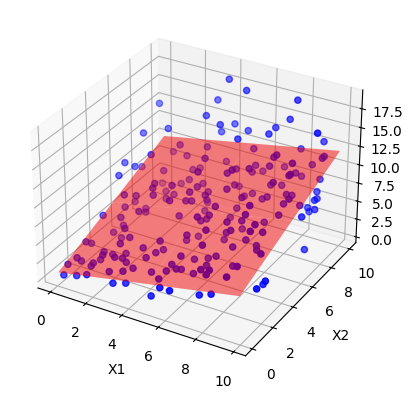

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5, rstride=100, cstride=100)
ax.scatter(X_train[:, 0], X_train[:, 1], t_train, c='blue', marker='o')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('t')
plt.show()

Finally, let's evaluate on the test set.

In [16]:
print(f'R2 score on the test set: {model.score(X_test, t_test):.3f}')

R2 score on the test set: 0.414


In this way, we can use the single `LinearRegression` estimator to fit lines, planes, or hyperplanes to our data.
It still appears that this approach would be limited to strictly linear relationships between variables, but it turns out we can relax this as well.

## Basis Function Regression

One trick you can use to adapt linear regression to nonlinear relationships between variables is to transform the data according to *basis functions*.
The idea is to take our multidimensional linear model:
$$
y(\textbf{x}) = w_0 +  \sum_{j=1}^{d} w_jx_j = \textbf{w}^T \textbf{x} = w_0 + w_1 x_1 + \cdots + w_j x_j
$$
and build the $x_1, x_2, x_3,$ and so on from our single-dimensional input $x$.
That is, we let $x_n = f_n(x)$, where $f_n()$ is some function that transforms our data.

For example, if $f_n(x) = x^n$, our model becomes a polynomial regression:
$$
y(x, \textbf{w}) = w_0 +  \sum_{j=1}^{M} w_jx^j = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M
$$
Notice that this is *still a linear model*—the linearity refers to the fact that the coefficients $w_j$ never multiply or divide each other.
What we have effectively done is taken our one-dimensional $x$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.

### Polynomial Basis Functions
This polynomial projection is useful enough that it is built into Scikit-Learn, using the `PolynomialFeatures` transformer:

In [17]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(2, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.],
       [ 3.,  9.],
       [ 4., 16.]])

In [18]:
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

We see here that the transformer has converted our one-dimensional array into a three-dimensional array, where each column contains the exponentiated value.
This new, higher-dimensional data representation can then be plugged into a linear regression.

The cleanest way to achieve this is to use a pipeline.

Let's create some data that do not have a linear shape.

In [19]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(250)
t = np.sin(X) + 0.1 * rng.randn(250)

Let's visualize our input features with respect the target value.

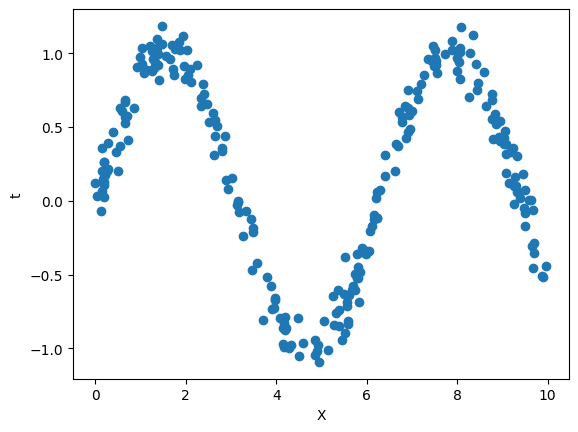

In [20]:
plt.figure()
plt.scatter(X,t)
plt.xlabel('X')
plt.ylabel('t')
plt.show()

Let's create our training and test data.

In [21]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, shuffle=True) 

Now we will fit a model with different polynomial grade and we will compare the results. Let's fit our model.

R2 score on the test set with Pol_1: -0.125
R2 score on the test set with Pol_2: 0.018
R2 score on the test set with Pol_3: 0.064
R2 score on the test set with Pol_4: 0.850
R2 score on the test set with Pol_5: 0.884
R2 score on the test set with Pol_6: 0.962


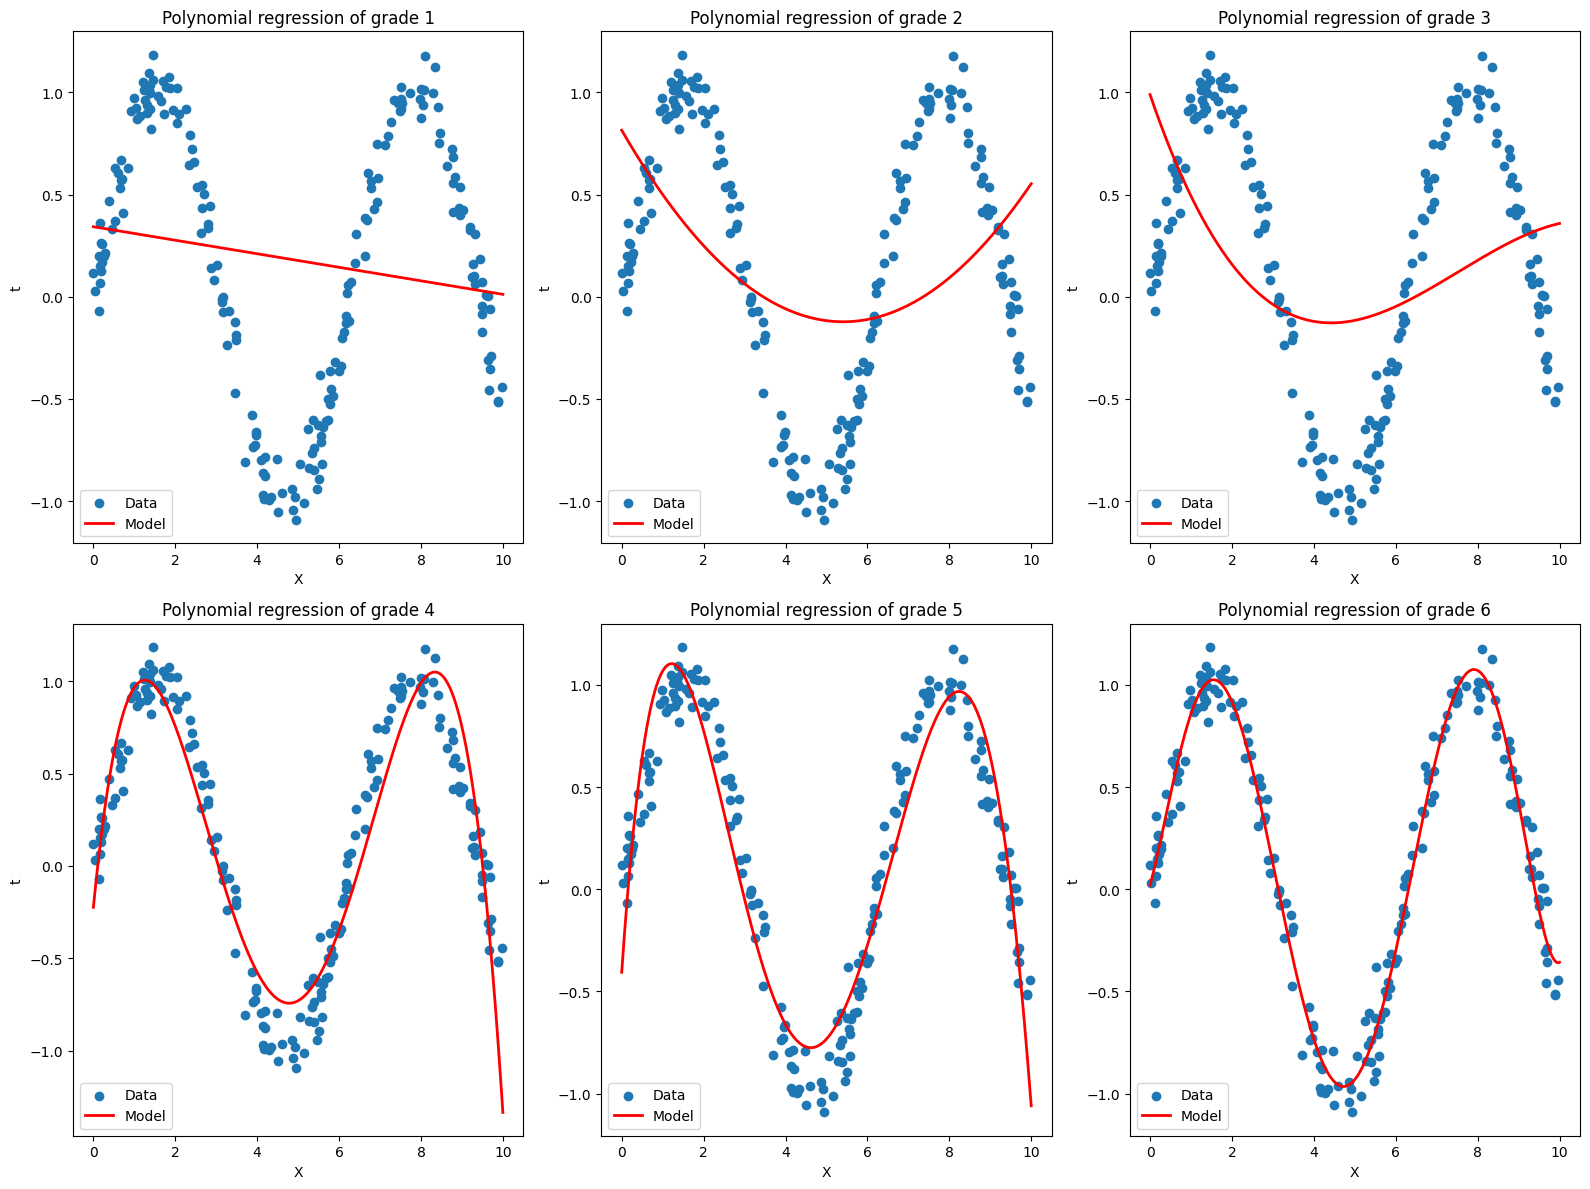

In [22]:
from sklearn.pipeline import make_pipeline

fig, axes = plt.subplots(2, 3, figsize=(16,12))
axes = axes.flatten()

X_fit = np.linspace(0, 10, 1000)

for i, ax in enumerate(axes):
    poly_model = make_pipeline(PolynomialFeatures(i+1),
                           LinearRegression(fit_intercept=True, n_jobs=-1))
    
    poly_model.fit(X_train[:, np.newaxis], t_train)
    t_fit = poly_model.predict(X_fit[:, np.newaxis])
    
    print(f'R2 score on the test set with Pol_{i+1}: '
          f'{poly_model.score(X_test[:, np.newaxis], t_test):.3f}')
    
        
    ax.scatter(X_train, t_train, marker='o')
    ax.plot(X_fit, t_fit, color='red', linewidth=2)
    ax.set_title(f'Polynomial regression of grade {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('t')
    ax.legend(['Data', 'Model'], loc='best')
    
plt.tight_layout()
plt.show()

Our linear model, through the use of different-order polynomial basis functions, can provide an excellent fit to this nonlinear data! Of course, other basis functions are possible.